# IMPORTS

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import sys
sys.path.append('/mnt/qb/work/goswami/gkd020/nvidia/github/')
from my_data_loader_xarray_FourCastNetV2 import my_select, to_xarray_dataset, calculate_relative_humidity, normalize_dataset
import torch
sys.path.append('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/ai_models_fourcastnet')
from afnonet import AFNONet
import matplotlib.pyplot as plt
import modulus

torch.cuda.is_available()

/mnt/qb/work/goswami/gkd020/miniforge3/envs/nvidia_mamba/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/qb/work/goswami/gkd020/miniforge3/envs/nvidia_mamba/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/mnt/qb/work/goswami/gkd020/miniforge3/envs/nvidia_mamba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
torch.cuda.mem_get_info()[0] // 1024 ** 2

39911

# SETUP

In [3]:
delta_days_past = 14
delta_days_future = 7
delta_frequency = '6H'
fcn_version = 0
number_of_channels = 20 # 20 for FCN V1, 26 for FCN V2

date = "2015-03-16"
certain_date_np = np.datetime64(date)
start_date = certain_date_np - np.timedelta64(delta_days_past, 'D')
end_date = certain_date_np + np.timedelta64(delta_days_future, 'D')
time_range = pd.date_range(start_date, end_date, freq=delta_frequency)
year = np.datetime_as_string(certain_date_np, unit='Y')

# LOAD MODEL

In [4]:
def load_model_state_dict(model, checkpoint):
    try:
        # Try adding model weights as dictionary
        new_state_dict = dict()
        for k, v in checkpoint["model_state"].items():
            name = k[7:]
            if name != "ged":
                new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    except Exception:
        model.load_state_dict(checkpoint["model_state"])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if fcn_version == 0 and number_of_channels == 20:
    model = AFNONet(in_chans=number_of_channels, out_chans=number_of_channels)
    model.zero_grad()
    checkpoint_path = "/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_backbone.ckpt"
    checkpoint = torch.load(checkpoint_path)
    load_model_state_dict(model, checkpoint)

elif fcn_version == 1 and number_of_channels == 26:
    model = AFNONet(in_chans=number_of_channels, out_chans=number_of_channels)
    model.zero_grad()
    checkpoint_path = "/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_backbone_v0.1.ckpt"
    checkpoint = torch.load(checkpoint_path)

    load_model_state_dict(model, checkpoint)

# fck nvidia
elif fcn_version == 2 and number_of_channels == 26:
    model = modulus.Module.from_checkpoint("/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_fcn_01.mdlus")

elif fcn_version == 3 and number_of_channels == 26:
    model = modulus.Module.from_checkpoint("/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_fcn_02.mdlus")
else:
    raise ValueError("Unsupported combination of fcn_version and number_of_channels")

model.to(device)
model.eval()


AFNONet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(20, 768, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (filter): AFNO2D()
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=1280, bias=False)
)

In [6]:
torch.cuda.mem_get_info()[0] // 1024 ** 2

38655

# LOAD DATASET

In [7]:
#big_ds = xr.open_dataset('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnetv2/FourCastNetV2_test_xarray.nc')
# big_ds = xr.open_dataset('/mnt/qb/datasets/STAGING/goswami/nvidia_daniel/2015-03-16_mjo_filtered.nc')

# if number_of_channels == 20:
#     data_set_path = "/mnt/qb/datasets/STAGING/goswami/nvidia_daniel/2015-03-16_mjo_filtered.nc"
# elif number_of_channels == 26:
#     data_set_path = "/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnetv2/FourCastNetV2_test_xarray.nc"
# else:
#     raise ValueError("No correct data_set_path for the given fcn_version and number_of_channels combination.")

# big_ds = xr.open_dataset(data_set_path)

# big_ds = my_select(big_ds, time_range)
file_paths = {}
file_paths['u10'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/10m_u_component_of_wind/10m_u_component_of_wind_{year}.nc", 0, 'u')
file_paths['v10'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/10m_v_component_of_wind/10m_v_component_of_wind_{year}.nc", 1, 'v')
file_paths['temp_2m'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/2m_temperature/2m_temperature_{year}.nc", 2, 't2m')
file_paths['sp'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/surface_pressure/surface_pressure_{year}.nc", 3, 'sp')
file_paths['mslp'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/mean_sea_level_pressure/mean_sea_level_pressure_{year}.nc", 4, 'mslp')
pressure_1000 = "1000"
file_paths['u_1000'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/u_component_of_wind/{pressure_1000}/u_component_of_wind_{year}_{pressure_1000}.nc", 6, 'u')
file_paths['v_1000'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/v_component_of_wind/{pressure_1000}/v_component_of_wind_{year}_{pressure_1000}.nc", 7, 'v')
file_paths['z_1000'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/geopotential/{pressure_1000}/geopotential_{year}_{pressure_1000}.nc", 8, 'z')
pressure_850 = "850"
file_paths['t_850'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/temperature/{pressure_850}/temperature_{year}_{pressure_850}.nc", 5, 't')
file_paths['u_850'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/u_component_of_wind/{pressure_850}/u_component_of_wind_{year}_{pressure_850}.nc", 9, 'u')
file_paths['v_850'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/v_component_of_wind/{pressure_850}/v_component_of_wind_{year}_{pressure_850}.nc", 10, 'v')
file_paths['z_850'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/geopotential/{pressure_850}/geopotential_{year}_{pressure_850}.nc", 11, 'z')
file_paths['rh_850'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/specific_humidity/{pressure_850}/specific_humidity_{year}_{pressure_850}.nc", 18, 'r')
pressure_500 = "500"
file_paths['t_500'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/temperature/{pressure_500}/temperature_{year}_{pressure_500}.nc", 15, 't')
file_paths['u_500'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/u_component_of_wind/{pressure_500}/u_component_of_wind_{year}_{pressure_500}.nc", 12, 'u')
file_paths['v_500'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/v_component_of_wind/{pressure_500}/v_component_of_wind_{year}_{pressure_500}.nc", 13, 'v')
file_paths['z_500'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/geopotential/{pressure_500}/geopotential_{year}_{pressure_500}.nc", 14, 'z')
file_paths['rh_500'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/specific_humidity/{pressure_500}/specific_humidity_{year}_{pressure_500}.nc", 17, 'r')
pressure_50 = "50"
file_paths['z_50'] = (f"/mnt/qb/goswami/data/era5/multi_pressure_level/geopotential/{pressure_50}/geopotential_{year}_{pressure_50}.nc", 16, 'z')
file_paths['tcwv'] = (f"/mnt/qb/goswami/data/era5/single_pressure_level/total_column_water_vapour/total_column_water_vapour_{year}.nc", 19, 'tcwv')

# # ###############################################################################################################################################################

big_ds = to_xarray_dataset(file_paths)
big_ds = my_select(big_ds, time_range)
big_ds = calculate_relative_humidity(big_ds, year, 850)
big_ds = calculate_relative_humidity(big_ds, year, 500)
print("finished")

big_ds

Variable Name: u10
Source File: /mnt/qb/goswami/data/era5/single_pressure_level/10m_u_component_of_wind/10m_u_component_of_wind_2015.nc
channel_idx: 0
Short Name: u
Detected Data Variable Name: u10
________________________________________
Variable Name: v10
Source File: /mnt/qb/goswami/data/era5/single_pressure_level/10m_v_component_of_wind/10m_v_component_of_wind_2015.nc
channel_idx: 1
Short Name: v
Detected Data Variable Name: v10
________________________________________
Variable Name: temp_2m
Source File: /mnt/qb/goswami/data/era5/single_pressure_level/2m_temperature/2m_temperature_2015.nc
channel_idx: 2
Short Name: t2m
Detected Data Variable Name: t2m
________________________________________
Variable Name: sp
Source File: /mnt/qb/goswami/data/era5/single_pressure_level/surface_pressure/surface_pressure_2015.nc
channel_idx: 3
Short Name: sp
Detected Data Variable Name: sp
________________________________________
Variable Name: mslp
Source File: /mnt/qb/goswami/data/era5/single_press

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 85)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2015-03-02 ... 2015-03-23
Data variables: (12/20)
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    temp_2m    (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    mslp       (time, latitude, longitude) float32 ...
    t_850      (time, latitude, longitude) float32 ...
    ...         ...
    z_500      (time, latitude, longitude) float32 ...
    t_500      (time, latitude, longitude) float32 ...
    z_50       (time, latitude, longitude) float32 ...
    rh_500     (time, latitude, longitude) float32 66.33 66.33 ... 57.84 57.84
    rh_850     (time, latitude, longitude) float32 28.33 28.33 ... 10.44 10.44
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-15 09:44:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [8]:
numpy_dataset = big_ds.to_array().values.astype(np.float32).transpose(1,0,2,3)
np.info(numpy_dataset)

class:  ndarray
shape:  (85, 20, 721, 1440)
strides:  (4152960, 353001600, 5760, 4)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x7fefab902010
byteorder:  little
byteswap:  False
type: float32


# LOAD STATS

In [9]:
if fcn_version == 0 and number_of_channels == 20:
    means = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_global_means_fcn_00.npy').astype(np.float32)
    stds = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_global_stds_fcn_00.npy').astype(np.float32)
    means = means[:,:number_of_channels,:,:]
    stds = stds[:,:number_of_channels,:,:]
elif fcn_version == 1 and number_of_channels == 26:
    means = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_global_means_fcn_01.npy').astype(np.float32)
    stds = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/ecmwf_global_stds_fcn_01.npy').astype(np.float32)

    means = means[:,:number_of_channels,:,:]
    stds = stds[:,:number_of_channels,:,:]
elif fcn_version == 2 and number_of_channels == 26:
    means = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_global_means_fcn_01.npy').astype(np.float32)
    stds = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_global_stds_fcn_01.npy').astype(np.float32)
elif fcn_version == 3 and number_of_channels == 26:
    means = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_global_means_fcn_02.npy').astype(np.float32)
    stds = np.load('/mnt/qb/work/goswami/gkd020/nvidia/github/ai-models-fourcastnet/weights_stats/nvidia_global_stds_fcn_02.npy').astype(np.float32)
else:
    raise ValueError("No correct means and stds for the given fcn_version and number_of_channels combination.")

means.shape

(1, 20, 1, 1)

In [10]:
normalized_dataset = (numpy_dataset - means) / stds

In [11]:
np.around(np.mean(normalized_dataset, axis=(0, 2, 3)), 0) 

array([ 0., -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.,  0.,
        0., -0.,  4., -0., -0., -0., -0.], dtype=float32)

# AUTOREGRESSIVE INFERENCE

In [12]:
input_tensor = torch.from_numpy(normalized_dataset).to(device)
input_tensor = input_tensor[:,:,:720,:]
input_tensor.shape

torch.Size([85, 20, 720, 1440])

In [13]:
input_tensor[0].unsqueeze(0).shape

torch.Size([1, 20, 720, 1440])

In [14]:
torch.set_grad_enabled(False)

num_time_steps = len(input_tensor[:,0,0,0])

# Initialize lists to store the outputs
preds = torch.zeros((num_time_steps, number_of_channels, 720, 1440)).to(device)
# Loop over each time step
for t in range(num_time_steps):
    if t==0: #start of sequence
        first = model(input_tensor[t].unsqueeze(0))
        preds[t] = first
    else:
        if t < num_time_steps-1:
            future = model(input_tensor[t+1].unsqueeze(0))
            preds[t] = future


In [15]:
del input_tensor
del model
torch.cuda.empty_cache()

preds.shape

torch.Size([85, 20, 720, 1440])

In [16]:
preds.cpu().numpy()
stds_tensor = torch.from_numpy(stds).to(device)
means_tensor = torch.from_numpy(means).to(device)
preds = preds * stds_tensor + means_tensor

In [17]:
# free up some memory

del means_tensor
del stds_tensor

torch.cuda.empty_cache()

# check available memory
torch.cuda.mem_get_info()[0] // 1024 ** 2

31371

# PLOTS

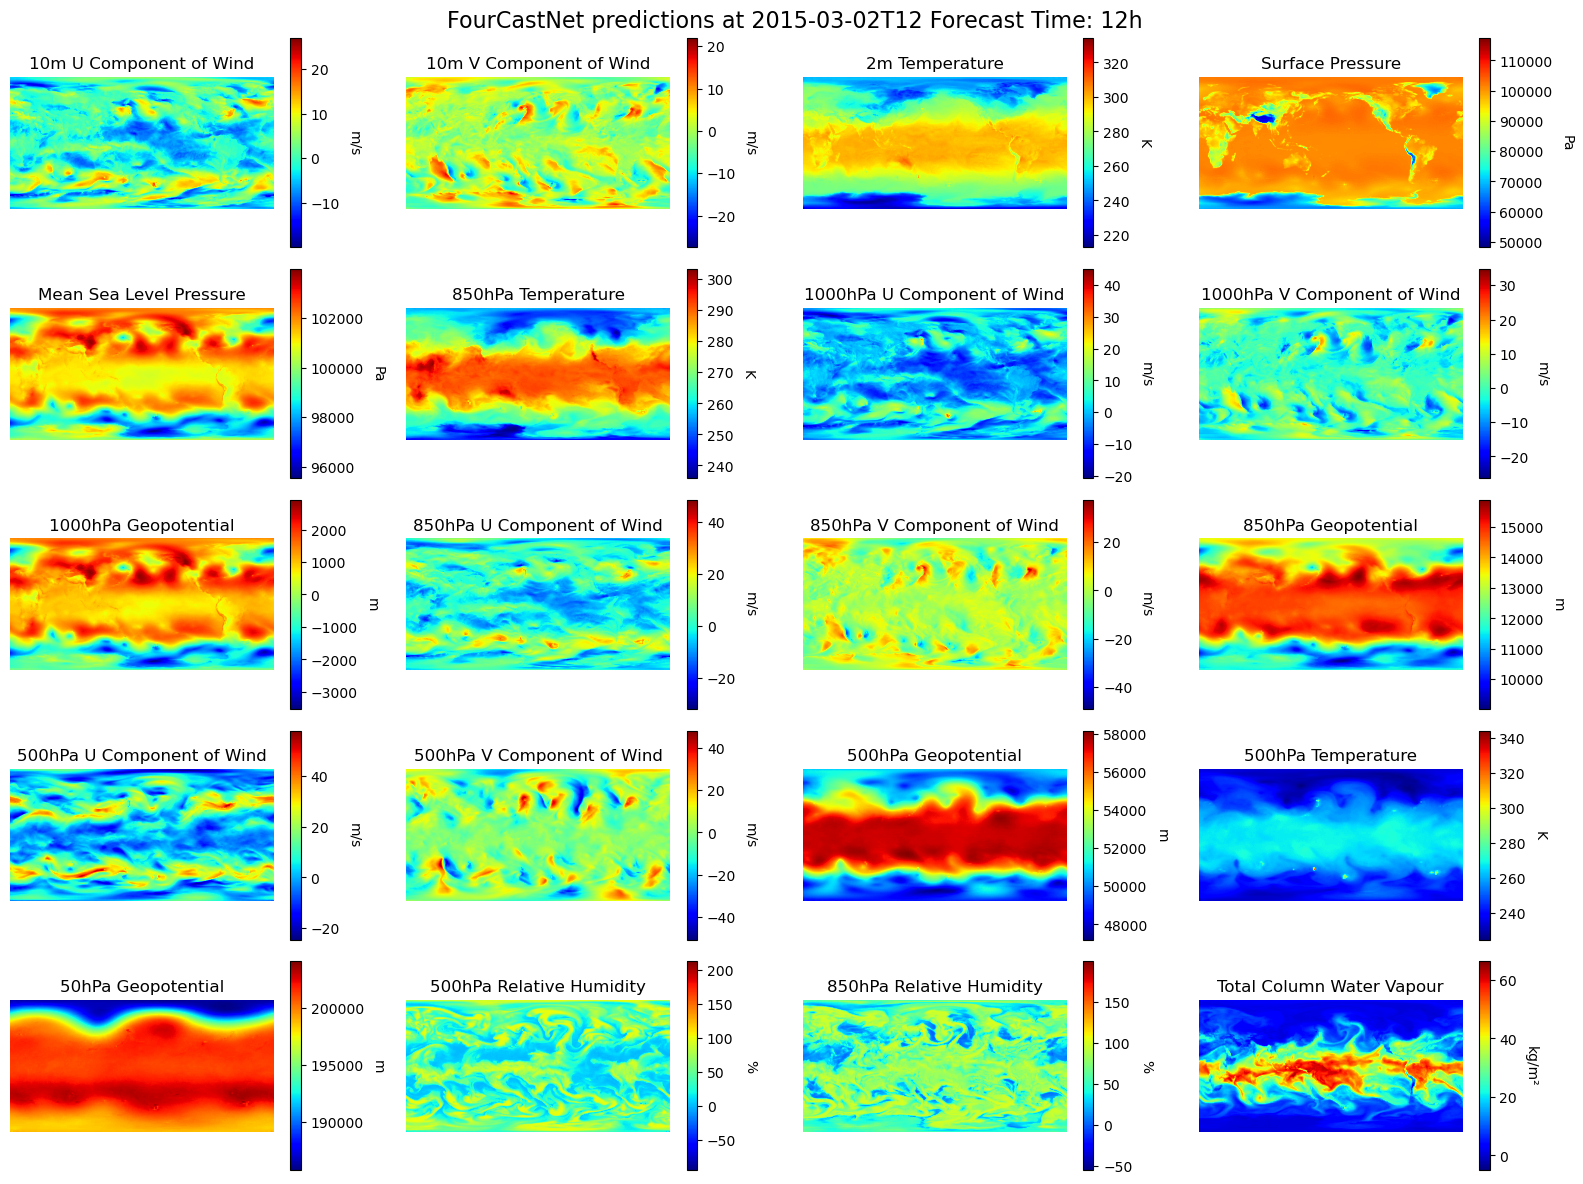

In [18]:
if number_of_channels == 20:
    channel_info = {
    'u10': {'description': '10m U Component of Wind', 'unit': 'm/s'},
    'v10': {'description': '10m V Component of Wind', 'unit': 'm/s'},
    'temp_2m': {'description': '2m Temperature', 'unit': 'K'},
    'sp': {'description': 'Surface Pressure', 'unit': 'Pa'},
    'mslp': {'description': 'Mean Sea Level Pressure', 'unit': 'Pa'},
    't_850': {'description': '850hPa Temperature', 'unit': 'K'},
    'u_1000': {'description': '1000hPa U Component of Wind', 'unit': 'm/s'},
    'v_1000': {'description': '1000hPa V Component of Wind', 'unit': 'm/s'},
    'z_1000': {'description': '1000hPa Geopotential', 'unit': 'm'},
    'u_850': {'description': '850hPa U Component of Wind', 'unit': 'm/s'},
    'v_850': {'description': '850hPa V Component of Wind', 'unit': 'm/s'},
    'z_850': {'description': '850hPa Geopotential', 'unit': 'm'},
    'u_500': {'description': '500hPa U Component of Wind', 'unit': 'm/s'},
    'v_500': {'description': '500hPa V Component of Wind', 'unit': 'm/s'},
    'z_500': {'description': '500hPa Geopotential', 'unit': 'm'},
    't_500': {'description': '500hPa Temperature', 'unit': 'K'},
    'z_50': {'description': '50hPa Geopotential', 'unit': 'm'},
    'rh_500': {'description': '500hPa Relative Humidity', 'unit': '%'},
    'rh_850': {'description': '850hPa Relative Humidity', 'unit': '%'},
    'tcwv': {'description': 'Total Column Water Vapour', 'unit': 'kg/m²'}
    }
elif number_of_channels == 26:
    channel_info = {
    "10u": {"description": "10m U Component of Wind", "unit": "m/s"},
    "10v": {"description": "10m V Component of Wind", "unit": "m/s"},
    "2t": {"description": "2m Temperature", "unit": "K"},
    "sp": {"description": "Surface Pressure", "unit": "Pa"},
    "msl": {"description": "Mean Sea Level Pressure", "unit": "Pa"},
    "t850": {"description": "850hPa Temperature", "unit": "K"},
    "u1000": {"description": "1000hPa U Component of Wind", "unit": "m/s"},
    "v1000": {"description": "1000hPa V Component of Wind", "unit": "m/s"},
    "z1000": {"description": "1000hPa Geopotential", "unit": "m"},
    "u850": {"description": "850hPa U Component of Wind", "unit": "m/s"},
    "v850": {"description": "850hPa V Component of Wind", "unit": "m/s"},
    "z850": {"description": "850hPa Geopotential", "unit": "m"},
    "u500": {"description": "500hPa U Component of Wind", "unit": "m/s"},
    "v500": {"description": "500hPa V Component of Wind", "unit": "m/s"},
    "z500": {"description": "500hPa Geopotential", "unit": "m"},
    "t500": {"description": "500hPa Temperature", "unit": "K"},
    "z50": {"description": "50hPa Geopotential", "unit": "m"},
    "r500": {"description": "500hPa Relative Humidity", "unit": "%"},
    "r850": {"description": "850hPa Relative Humidity", "unit": "%"},
    "tcwv": {"description": "Total Column Water Vapour", "unit": "kg/m²"},
    "100u": {"description": "100m U Component of Wind", "unit": "m/s"},
    "100v": {"description": "100m V Component of Wind", "unit": "m/s"},
    "u250": {"description": "250hPa U Component of Wind", "unit": "m/s"},
    "v250": {"description": "250hPa V Component of Wind", "unit": "m/s"},
    "z250": {"description": "250hPa Geopotential", "unit": "m"},
    "t250": {"description": "250hPa Temperature", "unit": "K"}
    }
else:
    raise ValueError("No correct means and stds for the given fcn_version and number_of_channels combination.")



# Extract the data for the chosen time step
time_index = data_to_plot = 2 # Index of the time dimension you want to select
# Select the specific time index and retrieve the underlying NumPy array
time_values = big_ds.isel(time=time_index).time.values
# Convert the array to datetime64
time_datetime = np.datetime64(time_values)

time_step_data = preds[time_index]  # This should have shape (20, 1440, 720)

# Determine the number of rows and columns for the subplots
num_channels = time_step_data.shape[0]
num_rows = num_channels // 4 if num_channels % 4 == 0 else num_channels // 4 + 1
num_cols = 4

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 12))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for channel_index, channel_key in enumerate(channel_info.keys()):
    ax = axes_flat[channel_index]
    im = ax.imshow(time_step_data[channel_index].cpu().numpy(), cmap='jet')
    ax.set_title(channel_info[channel_key]['description'])  # Set the description as title
    ax.axis('off')
    
    # Add a colorbar to the current axis with the unit as the label
    cbar = fig.colorbar(im, ax=ax)
    unit = channel_info[channel_key]['unit']
    cbar.set_label(unit, rotation=270, labelpad=15)

# Remove any unused subplots
for ax in axes_flat[num_channels:]:
    ax.remove()

fig.suptitle(f'FourCastNet predictions at {np.datetime_as_string(time_values, unit="h")} Forecast Time: {time_index*6}h', fontsize=16)
plt.tight_layout()
plt.show()


# RMSE calculations

In [19]:
targets = torch.from_numpy(numpy_dataset[:,:,:720,:]).to(device)

In [20]:
squared_diff = (preds - targets) ** 2
squared_diff.shape

torch.Size([85, 20, 720, 1440])

In [21]:
total_rmse = squared_diff.mean().sqrt()
total_rmse.shape

torch.Size([])

In [22]:
per_channel_rmse = squared_diff.mean(dim=(0,2,3)).sqrt()
per_channel_rmse.shape

torch.Size([20])

In [23]:
per_time_rmse = squared_diff.mean(dim=(1,2,3)).sqrt()
per_time_rmse.shape

torch.Size([85])

In [24]:
rmse_field = squared_diff.mean(dim=(0,1)).sqrt()
rmse_field.shape

torch.Size([720, 1440])

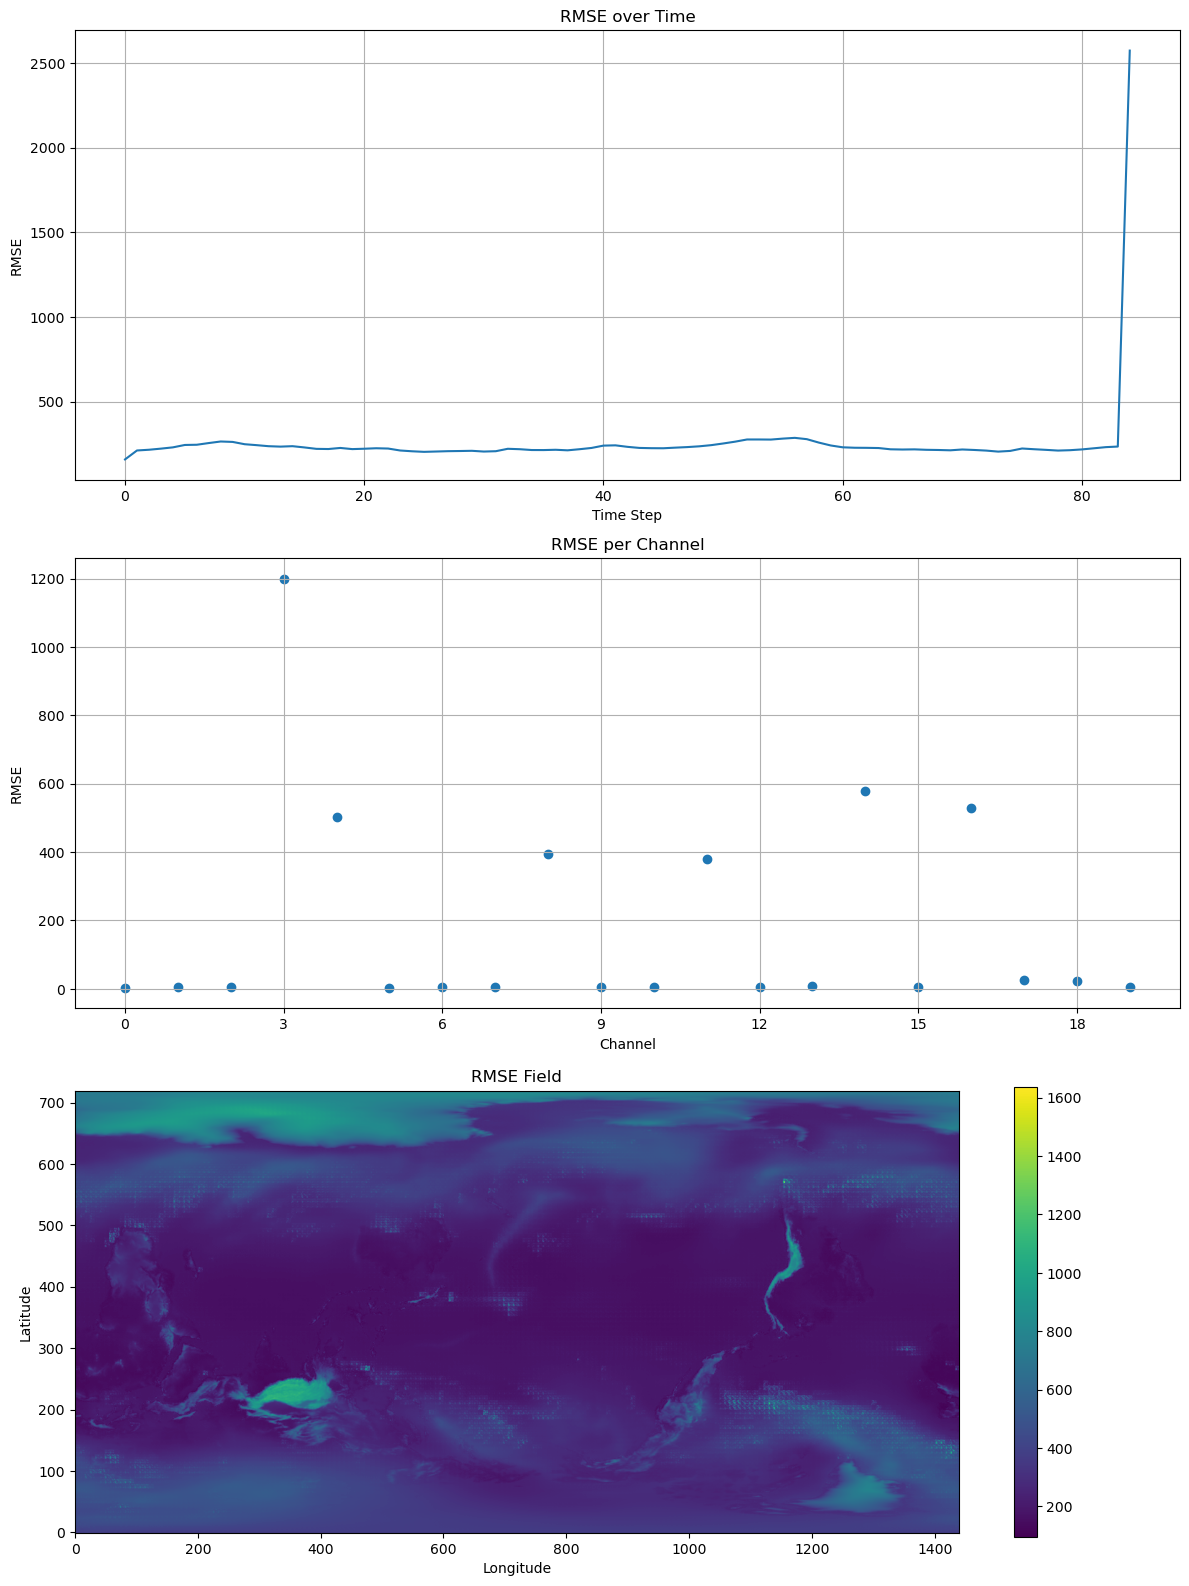

In [25]:
import matplotlib.ticker as ticker

# Move tensors to cpu and convert to numpy
per_time_rmse_np = per_time_rmse.cpu().numpy()
per_channel_rmse_np = per_channel_rmse.cpu().numpy()
rmse_field_np = rmse_field.cpu().numpy()

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

# Plot per_time_rmse
axs[0].plot(per_time_rmse_np)
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE over Time')
axs[0].grid(True)  # Add grid

# Plot per_channel_rmse as a scatter plot
axs[1].scatter(range(len(per_channel_rmse_np)), per_channel_rmse_np)
axs[1].set_xlabel('Channel')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE per Channel')
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axs[1].grid(True)  # Add grid

# Plot rmse_field as a 2D heatmap
img = axs[2].imshow(rmse_field_np, origin='lower')
fig.colorbar(img, ax=axs[2], orientation='vertical')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')
axs[2].set_title('RMSE Field')

# Show the plots
plt.tight_layout()
plt.show()

In [26]:
total_rmse

tensor(360.8623, device='cuda:0')

In [30]:
# shapes of all tensors:
rmse_field.shape, per_time_rmse.shape, per_channel_rmse.shape, total_rmse.shape

(torch.Size([720, 1440]), torch.Size([85]), torch.Size([20]), torch.Size([]))

In [33]:
# Create an xarray Dataset
data = xr.Dataset()

# Add tensors as variables to the Dataset
data['rmse_field'] = (['lat', 'lon'], rmse_field.cpu().numpy())
data['per_time_rmse'] = per_time_rmse.cpu().numpy()
data['per_channel_rmse'] = per_channel_rmse.cpu().numpy()
data['total_rmse'] = total_rmse.cpu().numpy()

# Add additional information as attributes
data.attrs['delta_days_past'] = delta_days_past
data.attrs['delta_days_future'] = delta_days_future
data.attrs['delta_frequency'] = delta_frequency
data.attrs['fcn_version'] = fcn_version
data.attrs['number_of_channels'] = number_of_channels
data.attrs['date'] = date

# Construct the file name
file_name = f"/mnt/qb/work/goswami/gkd020/outputs_rmse/{date}_FCN{fcn_version}_B{delta_days_past}_A{delta_days_future}.nc"

# Save the Dataset to a NetCDF file with the constructed file name
data.to_netcdf(file_name)